### Decoding animal's behaviors from neural data

__By Neuromatch Academy 2023 Deep Learning Agustinia-Tsam project team 2__

__Project team:__ Ke Chen, Mohammad Samavat, Raymond Shpeley, Dev laxman Subramanian, Arjun Verma

We use the Steinmetz dataset to decode animal behaviours over a range of neural network models to determine which models best correspond to mouse behaviours.

This notebook is coded by Dev Subramanian

___


##### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
import time
#%%
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import pickle

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from keras.models import Sequential

#Import metrics
#from metrics import get_R2
#from metrics import get_rho

#Import Bayesian Optimization package
#from bayes_opt import BayesianOptimization

#from tqdm.auto import tqdm
from IPython.display import display

#Import functions for Keras if Keras is installed
#Note that Keras has many more built-in functions that I have not imported because I have not used them
#But if you want to modify the decoders with other functions (e.g. regularization), import them here
try:
    import keras
    keras_v1=int(keras.__version__[0])<=1
    from keras.models import Sequential
    from keras.layers import Dense, LSTM, SimpleRNN, GRU, Activation, Dropout
    from keras.utils import np_utils
except ImportError:
    print("\nWARNING: Keras package is not installed. You will be unable to use all neural net decoders")
    pass

try:
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    print("\nWARNING: Sklearn OneHotEncoder not installed. You will be unable to use XGBoost for Classification")
    pass


Useful function to group data according to brain regions

In [2]:
def data_with_each_brain(dat, regions, brain_groups):
    data = {}
    data['all'] = dat['spks']
    nareas = 7  # only the top 7 regions are in this particular mouse
    NN = len(dat['brain_area'])  # number of neurons
    barea = nareas * np.ones(NN, )  # last one is "other"
    for j in range(nareas):
        barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

    counter = 0
    for region in regions:
        data[region] = dat['spks'][barea == counter]
        counter += 1

    for key in data:
        print(f"There are {len(data[key])} neurons recorded in {key}  region\n")
    
    for key in data:
        plt.figure(figsize = (10, 6))
        plt.imshow(data[key][:, 0, :], cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
        plt.xlabel('Time (ms)')
        plt.ylabel('Cell #')
        plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
        plt.title(f'Example trial in {key}')
        plt.show()
    return data


##### Set device to GPU or CPU

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##### Set random seed

In [4]:
# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


##### Data retrieval

In [6]:
# store the dataset files in the datasets folder
import os, requests

fname = []
ds = "../datasets"

for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile("/".join([ds, fname[j]])):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open("/".join([ds, fname[j]]), "wb") as fid:
          fid.write(r.content)

In [7]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load("/".join([ds, 'steinmetz_part%d.npz'%j]),
                              allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played.
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: [https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406](https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406)

##### Make a plot of which brain areas are present in each dataset
Note that region 4 ("other ctx" are neurons that were not able to be classified). Region 4 does not correspond to brain_group 4, which are all cortical neurons outside of the visual cortex.

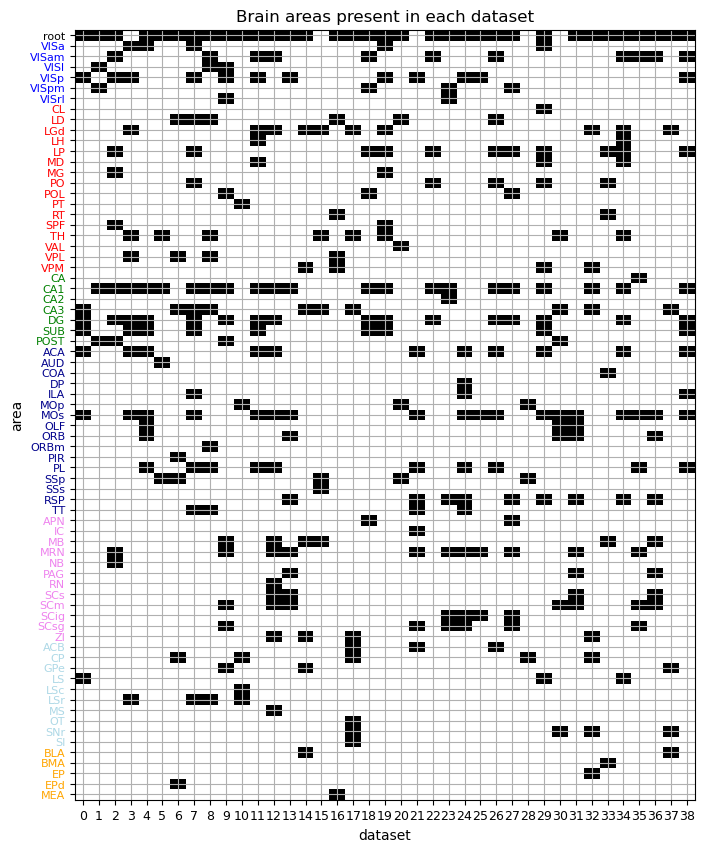

In [8]:
regions = ["vis_ctx", "thal", "hipp", "other_ctx", "midbrain", "basal_ganglia", "cortical_subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

**Predict the wheel speed from the neural data using a LSTM network.**


Currently using session 10 as it contained data from the primary motor cortex (447 neurons)

Previously used session 13 as it contained data from the secondary motor cortex (186 neurons) along with Visual cortex, hippocampus and retrosplenial cortex neurons

In [51]:
# select just one of the recordings here
dat = alldat[10]
print(dat.keys())

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape
ws = dat['wheel']
print(NT)

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive', 'motor_cortex', 'motor_cortex_correct'])
(857, 342, 250)


##### Visulize the data from one trial

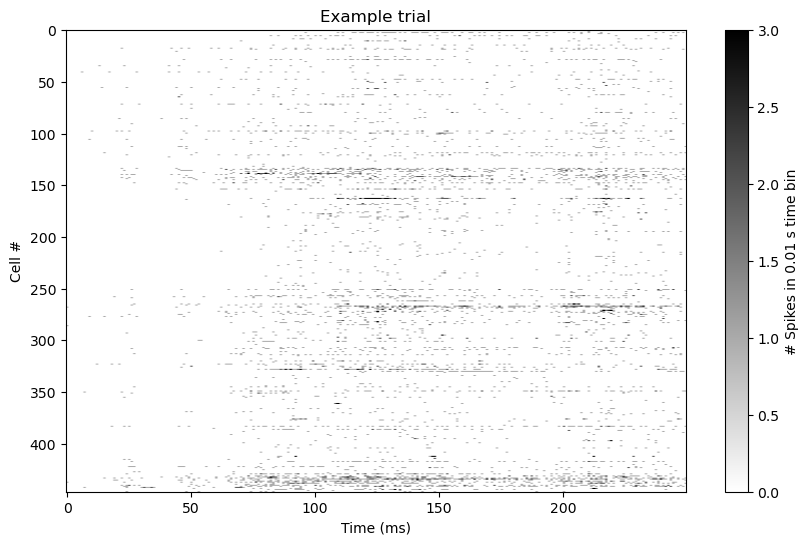

In [52]:
plt.figure(figsize = (10, 6))
plt.imshow(dat['spks'][dat['brain_area'] == 'MOp',0,:], cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title('Example trial')
plt.show()

**Prepare data for Deep Learning**

Spikes not normalized - can try normalizing them as well in the commented code block below to see if it makes any difference

In [54]:
# allAreas = dat["brain_area"]
# usedAreas = ['CA1', 'RSP', 'VISp', 'MOs']
# area=dict()
# cellN=np.zeros(4)
# for i in range(len(usedAreas)):
#     areaId = allAreas == usedAreas[i]
#     tmp_Area = dat['spks'][areaId, :, :]
#     area[i] = tmp_Area
#     # print(tmp_Area.shape)
#     # area[i] = frNormalization(tmp_Area)
#     cellN[i]=tmp_Area.shape[0]

# # area contain spikes from selected regions in usedAreas's order [index 0 -3 indicate each region]
# # area: row: trials; col: time bins
# print(area[0].shape)
# print(area[1].shape)
# print(area[2].shape)
# print(area[3].shape)
print(dat['spks'][dat['brain_area'] == 'CA1',:,:].shape)
print(dat['spks'][dat['brain_area'] == 'MOp',:,:].shape)
print(dat['spks'][dat['brain_area'] == 'MOs',:,:].shape)
print(dat['spks'][dat['brain_area'] == 'RSP',:,:].shape)
print(dat['spks'][dat['brain_area'] == 'VISp',:,:].shape)
#print(dat['spks'][dat['regions'] == 'vis_ctx',:,:].shape)
#print(cellN[2].shape)

(0, 342, 250)
(447, 342, 250)
(0, 342, 250)
(0, 342, 250)
(0, 342, 250)


(1, 342, 250)
1.0
1.4879751110369492
0.8168971348820161
(272, 1)
229.50866784498714
1.5536180841551186
62.760326889948814
[-1.  1.]
[ 70 272]
(447, 342, 100)


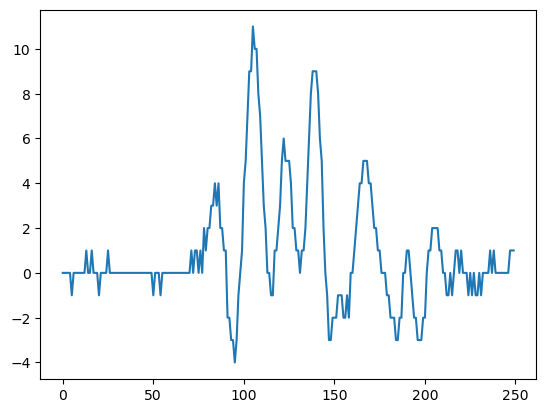

In [58]:
# Tried a bunch of things to check the dimensions of the appropriate input/output data for the model

print(dat['wheel'].shape)
print(dat['response'][1])
print(dat['feedback_time'].mean())
print(dat['gocue'].mean())
print(np.array(dat['feedback_time'][dat['feedback_type']==1]).shape)
print(np.array(dat['feedback_time'] - dat['gocue']).sum()) #only 158 seconds of data for the entire session 

print(np.array(dat['feedback_time'][dat['feedback_type']==1] - dat['gocue'][dat['feedback_type']==1]).max()) #only 102 seconds of data for the correct trials
print(np.array(dat['feedback_time'][dat['feedback_type']==-1] - dat['gocue'][dat['feedback_type']==-1]).sum())

uniques,counts = np.unique(dat['feedback_type'], return_counts=True)
print(uniques)
print(counts)
print(dat['spks'][dat['brain_area'] == 'MOp',:,50:150].shape)
plt.plot(dat['wheel'][0,3,:])

Visualize spiking data for just the time between auditory cue to the time mice got the reward for one trial

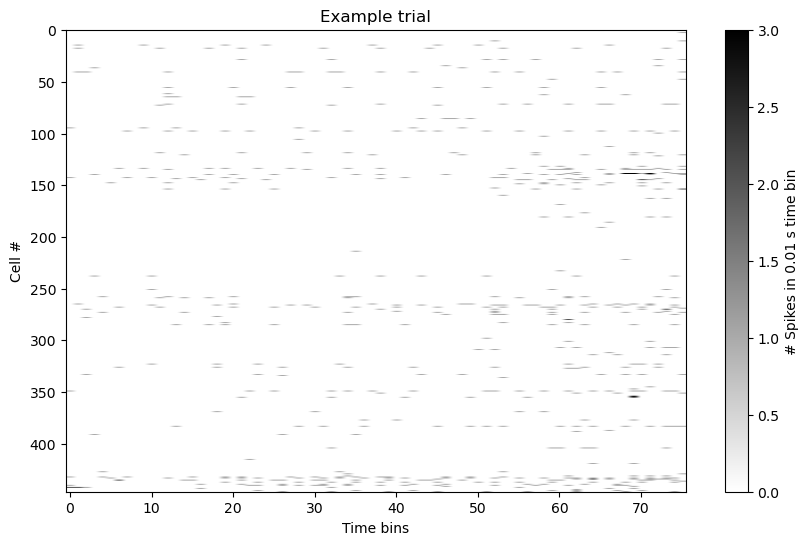

In [19]:
plt.figure(figsize = (10, 6))
plt.imshow(dat['spks'][dat['brain_area'] == 'MOp',1,(dat['gocue'][1]*100)[0].astype(int):(dat['feedback_time'][1]*100)[0].astype(int)], cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('Time bins')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title('Example trial')
plt.show()

**For using relevant data for the wheel speed prediction, constrain the data for each trial from the time after auditory cue to the time mice got the reward - so constrain from dat['gocue'] to dat['feedback_time']):
Easier approach is to probably take 50 to 150 bin no. i.e from 0.5 to 1.5 seconds after the trial start since the go cue comes around 0.58 seconds on average and the mice get the feedback around 1.2 seconds on average**

Comparison of the following brain regions/trial types:
1) Motor cortex - all trials 
2) Motor cortex - correct trials (using only correct trials improved prediction as compared to using all trials so correct trials are used for comparison across brain regions)
3) Other brain regions


1 second of data from each trial used for prediction - 100 time bins of 10 ms each; 186 correct trials present in session 13, so 186 seconds of data is used from all correct trials

In [59]:
#Data to be used for the model from the motor cortex from 0.5 to 1.5 seconds to predict the wheel speed for session 13 (correct trials only)
#Data to be used for the model from the motor cortex from 0.7 to 1.7 seconds to predict the wheel speed for session 10 (correct trials only)
#dat['motor_cortex']=dat['spks'][dat['brain_area'] == 'MOs',:,50:150]
dat['motor_cortex']=dat['spks'][dat['brain_area'] == 'MOp',:,70:170]

print(dat['motor_cortex'].shape)

# Get the correct trials
dat['motor_cortex_correct'] = dat['motor_cortex'][:,dat['feedback_type']==1,:]
print(dat['motor_cortex_correct'].shape)

#dat['wheel'][0,:,50:150].shape
dat['wheel'][0,dat['feedback_type']==1,70:170].shape

#dat['wheel'][0,:,50:150].shape

(447, 342, 100)
(447, 272, 100)


(272, 100)

In [23]:
# Toy example to verify the dimesion of the data after flattening
exam = torch.tensor([[[1, 2, 3, 0],[100, 400, 500, 800]], [[4, 5, 6, 8],[600, 700, 800, 900]], [[7, 8, 9, 0],[1000, 4000, 5000, 8000]]])
print(exam.shape)

X_exam = torch.flatten(exam, start_dim = 0, end_dim = 1)
print(X_exam.shape)
print(X_exam)

exam = torch.tensor([[1, 2, 3, 0],[100, 400, 500, 800]])
print(exam.shape)
Y_exam = torch.flatten(exam)
print(Y_exam.shape)
print(Y_exam)
print(Y_exam.reshape(-1, 1))
print(Y_exam.reshape(-1, 1).shape)
print(Y_exam)

torch.Size([3, 2, 4])
torch.Size([6, 4])
tensor([[   1,    2,    3,    0],
        [ 100,  400,  500,  800],
        [   4,    5,    6,    8],
        [ 600,  700,  800,  900],
        [   7,    8,    9,    0],
        [1000, 4000, 5000, 8000]])
torch.Size([2, 4])
torch.Size([8])
tensor([  1,   2,   3,   0, 100, 400, 500, 800])
tensor([[  1],
        [  2],
        [  3],
        [  0],
        [100],
        [400],
        [500],
        [800]])
torch.Size([8, 1])
tensor([  1,   2,   3,   0, 100, 400, 500, 800])


In [21]:
# Permuting spike data from Neurons x Trials x Time Bins ---to--- Trials x Time Bins x Neurons to serve as input
x = torch.tensor(dat['motor_cortex_correct']).permute(1,2,0)
print(x.shape)
#print(x[0])

# Flattening the data so that the input is a 2D matrix of (Trials x Time Bins) x Neurons
X_flat = torch.flatten(x, start_dim = 0, end_dim = 1)
#X = x
X_flat= X_flat.numpy()
print(X_flat.shape)
#print(X[0])

y = torch.tensor(dat['wheel'][0,dat['feedback_type']==1,70:170])
print(y.shape)
#print(y[0])
# Flattening the data so that the output is a column vector of size (Trials x Time Bins)
Y = torch.flatten(y)
#Y = y
Y = Y.numpy()
print(Y.shape)
Y = Y.reshape(-1, 1)
print(Y.shape)
#print(Y[0])



torch.Size([272, 100, 447])
(27200, 447)
torch.Size([272, 100])
(27200,)
(27200, 1)


**Neural history for prediction: Used 15 bins neural activity before the current bin along with the current bin to predict the wheel speed in a given bin - so basically using around 150ms of neural activity to predict the wheel speed in the current bin to account for the reaction time of the mouse**

(currently using 150 ms of neural history for prediction - tried with 250 ms to see if the accuracy improves but it didn't make much difference)

In [22]:
###$$ GET_SPIKES_WITH_HISTORY #####
def get_spikes_with_history(neural_data,bins_before,bins_after,bins_current=1):
    """
    Function that creates the covariate matrix of neural activity

    Parameters
    ----------
    neural_data: a matrix of size "number of time bins" x "number of neurons"
        the number of spikes in each time bin for each neuron
    bins_before: integer
        How many bins of neural data prior to the output are used for decoding
    bins_after: integer
        How many bins of neural data after the output are used for decoding
    bins_current: 0 or 1, optional, default=1
        Whether to use the concurrent time bin of neural data for decoding

    Returns
    -------
    X: a matrix of size "number of total time bins" x "number of surrounding time bins used for prediction" x "number of neurons"
        For every time bin, there are the firing rates of all neurons from the specified number of time bins before (and after)
    """

    num_examples=neural_data.shape[0] #Number of total time bins we have neural data for
    num_neurons=neural_data.shape[1] #Number of neurons
    surrounding_bins=bins_before+bins_after+bins_current #Number of surrounding time bins used for prediction
    X=np.empty([num_examples,surrounding_bins,num_neurons]) #Initialize covariate matrix with NaNs
    X[:] = np.NaN
    #Loop through each time bin, and collect the spikes occurring in surrounding time bins
    #Note that the first "bins_before" and last "bins_after" rows of X will remain filled with NaNs, since they don't get filled in below.
    #This is because, for example, we cannot collect 10 time bins of spikes before time bin 8
    start_idx=0
    for i in range(num_examples-bins_before-bins_after): #The first bins_before and last bins_after bins don't get filled in
        end_idx=start_idx+surrounding_bins; #The bins of neural data we will be including are between start_idx and end_idx (which will have length "surrounding_bins")
        X[i+bins_before,:,:]=neural_data[start_idx:end_idx,:] #Put neural data from surrounding bins in X, starting at row "bins_before"
        start_idx=start_idx+1;
    return X

In [23]:
bins_before=15 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0#How many bins of neural data after the output are used for decoding

In [24]:
# Format for recurrent neural networks (LSTM & others)
# Function to get the covariate matrix that includes spike history from previous bins

X = get_spikes_with_history(X_flat, bins_before, bins_after, bins_current)
print(X.shape)

(27200, 16, 447)


**Splitting the data into train, test and validation sets - 80% train, 10% test and 10% validation. Then, doing a 10 fold Cross Validation...so in the first fold, for example, 0-10% is validation, 10-20% is testing, and 20-100% is training.**

In [25]:
valid_range_all=[[0,.1],[.1,.2],[.2,.3],[.3,.4],[.4,.5],
                     [.5,.6],[.6,.7],[.7,.8],[.8,.9],[.9,1]]
testing_range_all=[[.1,.2],[.2,.3],[.3,.4],[.4,.5],[.5,.6],
                     [.6,.7],[.7,.8],[.8,.9],[.9,1],[0,.1]]
    #Note that the training set is not aways contiguous. For example, in the second fold, the training set has 0-10% and 30-100%.
    #In that example, we enter of list of lists: [[0,.1],[.3,1]]
training_range_all=[[[.2,1]],[[0,.1],[.3,1]],[[0,.2],[.4,1]],[[0,.3],[.5,1]],[[0,.4],[.6,1]],
                       [[0,.5],[.7,1]],[[0,.6],[.8,1]],[[0,.7],[.9,1]],[[0,.8]],[[.1,.9]]]

num_folds=len(valid_range_all) #Number of cross validation folds

    #R2 values
mean_r2_lstm=np.empty(num_folds)

In [26]:
#Actual data
y_test_all=[]
y_train_all=[]
y_valid_all=[]

#Test predictions
y_pred_lstm_all=[]
dec_error_all = []

#Training predictions
y_train_pred_lstm_all=[]

#Validation predictions
y_valid_pred_lstm_all=[]

t1 = time.time()  # If I want to keep track of how much time has elapsed

num_examples = X.shape[0]  # number of examples (rows in the X matrix)
print(num_examples)


27200


In [29]:
class LSTMRegression(object):

    """
    Class for the LSTM decoder for  Regression

    Parameters
    ----------
    units: integer, optional, default 400
        Number of hidden units in each layer

    dropout: decimal, optional, default 0.2
        Proportion of units that get dropped out

    num_epochs: integer, optional, default 10
        Number of epochs used for training

    verbose: binary, optional, default=0
        Whether to show progress of the fit after each epoch
    """

    def __init__(self,units=400,dropout=0.2,num_epochs=10,verbose=0):
         self.units=units
         self.dropout=dropout
         self.num_epochs=num_epochs
         self.verbose=verbose


    def fit(self,X_train,y_train):

        """
        Train LSTM Decoder

        Parameters
        ----------
        X_train: numpy 3d array of shape [n_samples,n_time_bins,n_neurons]
            This is the neural data.
            See example file for an example of how to format the neural data correctly

        y_train: numpy 2d array of shape [n_samples, n_outputs]
            This is the outputs that are being predicted
        """

        model=Sequential() #Declare model
        #Add recurrent layer
        if keras_v1:
            model.add(LSTM(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout)) #Within recurrent layer, include dropout
        else:
            model.add(LSTM(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout=self.dropout,recurrent_dropout=self.dropout)) #Within recurrent layer, include dropout
        if self.dropout!=0: model.add(Dropout(self.dropout)) #Dropout some units (recurrent layer output units)

        #Add dense connections to output layer
        model.add(Dense(y_train.shape[1]))

        #Fit model (and set fitting parameters)
        model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy']) #Set loss function and optimizer
        if keras_v1:
            model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
        else:
            model.fit(X_train,y_train,epochs=self.num_epochs,verbose=self.verbose) #Fit the model
        self.model=model


    def predict(self,X_test):

        """
        Predict outcomes using trained LSTM Decoder

        Parameters
        ----------
        X_test: numpy 3d array of shape [n_samples,n_time_bins,n_neurons]
            This is the neural data being used to predict outputs.

        Returns
        -------
        y_test_predicted: numpy 2d array of shape [n_samples,n_outputs]
            The predicted outputs
        """

        y_test_predicted = self.model.predict(X_test) #Make predictions
        return y_test_predicted

**Use the following two blocks of code if you want to do Bayesian Optimization to find the best hyperparameters for the model**

In [ ]:
### Get hyperparameters using Bayesian optimization based on validation set R2 values###

# Define a function that returns the metric we are trying to optimize (R2 value of the validation set)
# as a function of the hyperparameter we are fitting
def lstm_evaluate(num_units, frac_dropout, n_epochs):
    num_units = int(num_units)
    frac_dropout = float(frac_dropout)
    n_epochs = int(n_epochs)
    model_lstm = LSTMRegression(units=num_units, dropout=frac_dropout, num_epochs=n_epochs)
    model_lstm.fit(X_train, y_train)
    y_valid_predicted_lstm = model_lstm.predict(X_valid)
    return np.mean(get_R2(y_valid, y_valid_predicted_lstm))

In [ ]:
# Do bayesian optimization
# lstmBO = BayesianOptimization(lstm_evaluate,
#                               {'num_units': (50, 600), 'frac_dropout': (0, .5), 'n_epochs': (2, 21)})
# lstmBO.maximize(init_points=20, n_iter=20, kappa=10)
# best_params = lstmBO.max['params']
# frac_dropout = float(best_params['frac_dropout'])
# n_epochs = np.int(best_params['n_epochs'])
# num_units = np.int(best_params['num_units'])
print(X_train.shape)

(214, 100, 186)


In [ ]:
print('Best parameters found: ', best_params)

**SCORING METRIC: 
To determine the goodness of fit, we used R2=1−∑i(yˆi−yi)2∑i(yi−y¯)2, where yˆi are the predicted values, yi are the true values, and y¯ is the mean value. This formulation of R2 (Serruya et al., 2003; Fagg et al., 2009; which is the fraction of variance accounted for, rather than the squared Pearson’s correlation coefficient) can be negative on the test set because of overfitting on the training set.** Source: https://www.eneuro.org/content/7/4/ENEURO.0506-19.2020

R2 score (coefficient of determination) - how well the model fits the data. R2 score of 1 means the model fits the data perfectly, R2 score of 0 means the model does not fit the data at all, and R2 score of negative means the model fits the data worse than a horizontal line (i.e. the mean of the data)

In [47]:
def get_R2(y_test,y_test_pred):

    """
    Function to get R2

    Parameters
    ----------
    y_test - the true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred - the predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    R2_array: An array of R2s for each output
    """

    R2_list=[] #Initialize a list that will contain the R2s for all the outputs
    for i in range(y_test.shape[1]): #Loop through outputs
        #Compute R2 for each output
        y_mean=np.mean(y_test[:,i])
        R2=1-np.sum((y_test_pred[:,i]-y_test[:,i])**2)/np.sum((y_test[:,i]-y_mean)**2)
        R2_list.append(R2) #Append R2 of this output to the list
    R2_array=np.array(R2_list)
    return R2_array #Return an array of R2s

In [30]:
save_folder= "save wherever you want"

for i in range(num_folds):  # Loop through the folds

    ######### SPLIT DATA INTO TRAINING/TESTING/VALIDATION #########

    # Note that all sets have a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
    # This makes it so that the different sets don't include overlapping neural data

    # Get testing set for this fold
    testing_range = testing_range_all[i]
    testing_set = np.arange(np.int(np.round(testing_range[0] * num_examples)) + bins_before,
                            np.int(np.round(testing_range[1] * num_examples)) - bins_after)

    # Get validation set for this fold
    valid_range = valid_range_all[i]
    valid_set = np.arange(np.int(np.round(valid_range[0] * num_examples)) + bins_before,
                            np.int(np.round(valid_range[1] * num_examples)) - bins_after)

    # Get training set for this fold.
    # Note this needs to take into account a non-contiguous training set (see section 3C)
    training_ranges = training_range_all[i]
    for j in range(len(training_ranges)):  # Go through different separated portions of the training set
        training_range = training_ranges[j]
        if j == 0:  # If it's the first portion of the training set, make it the training set
            training_set = np.arange(np.int(np.round(training_range[0] * num_examples)) + bins_before,
                                        np.int(np.round(training_range[1] * num_examples)) - bins_after)
        if j == 1:  # If it's the second portion of the training set, concatentate it to the first
            training_set_temp = np.arange(np.int(np.round(training_range[0] * num_examples)) + bins_before,
                                            np.int(np.round(training_range[1] * num_examples)) - bins_after)
            training_set = np.concatenate((training_set, training_set_temp), axis=0)

    # Get training data
    X_train = X[training_set, :]
    y_train = Y[training_set, :]

    # Get testing data
    X_test = X[testing_set, :]
    y_test = Y[testing_set, :]

    # Get validation data
    X_valid = X[valid_set, :]
    y_valid = Y[valid_set, :]

    # # Z-score "X" inputs.
    # X_train_mean = np.nanmean(X_train, axis=0)  # Mean of training data
    # X_train_std = np.nanstd(X_train, axis=0)  # Stdev of training data
    # X_train = (X_train - X_train_mean) / X_train_std  # Z-score training data
    # X_test = (X_test - X_train_mean) / X_train_std  # Preprocess testing data in same manner as training data
    # X_valid = (X_valid - X_train_mean) / X_train_std  # Preprocess validation data in same manner as training data

    # Zero-center outputs
    # y_train_mean = np.nanmean(y_train, axis=0)  # Mean of training data outputs
    # y_train = y_train - y_train_mean  # Zero-center training output
    # y_test = y_test - y_train_mean  # Preprocess testing data in same manner as training data
    # y_valid = y_valid - y_train_mean  # Preprocess validation data in same manner as training data

    # Add actual train/valid/test data to lists (for saving)
    y_test_all.append(y_test)
    y_train_all.append(y_train)
    y_valid_all.append(y_valid)

    # Fit LSTM
    # Run model w/ below hyperparameters
    model_lstm = LSTMRegression(units=200, dropout=0.3, num_epochs=10)
    model_lstm.fit(X_train, y_train)
    y_test_predicted_lstm = model_lstm.predict(X_test)
    mean_r2_lstm[i] = np.mean(get_R2(y_test, y_test_predicted_lstm))
    # Print test set R2
    R2s_lstm = get_R2(y_test, y_test_predicted_lstm)
    print('R2s:', R2s_lstm)
    # Add predictions of training/validation/testing to lists (for saving)
    y_pred_lstm_all.append(y_test_predicted_lstm)
    y_train_pred_lstm_all.append(model_lstm.predict(X_train))
    y_valid_pred_lstm_all.append(model_lstm.predict(X_valid))

save_obj = {'y_test_all':y_test_all, 'y_valid_all': y_valid_all, 'y_train_all': y_train_all, 'mean_r2_lstm': mean_r2_lstm, 'y_pred_lstm_all':y_pred_lstm_all, 'y_train_pred_lstm_all':y_train_pred_lstm_all, 'y_valid_pred_lstm_all':y_valid_pred_lstm_all, 'X': X, 'Y': Y}

with open(save_folder + 'results_lstm_regression_MOp_session_10_w_labels_200_units_150ms_history_correct_trials_100_time_bins_447_neurons.pickle', 'wb') as f:
    pickle.dump(save_obj, f) 


C:\Users\sdevl\AppData\Local\Temp\ipykernel_11180\2300645783.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  testing_set = np.arange(np.int(np.round(testing_range[0] * num_examples)) + bins_before,
C:\Users\sdevl\AppData\Local\Temp\ipykernel_11180\2300645783.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

85/85 [==============================] - 2s 17ms/step
R2s: [0.87940014]
85/85 [==============================] - 2s 17ms/step


C:\Users\sdevl\AppData\Local\Temp\ipykernel_11180\2300645783.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set_temp = np.arange(np.int(np.round(training_range[0] * num_examples)) + bins_before,
C:\Users\sdevl\AppData\Local\Temp\ipykernel_11180\2300645783.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

85/85 [==============================] - 2s 16ms/step
R2s: [0.89032921]
85/85 [==============================] - 2s 15ms/step
R2s: [0.90603079]
85/85 [==============================] - 2s 15ms/step
R2s: [0.90781023]
85/85 [==============================] - 2s 15ms/step
R2s: [0.91366865]
85/85 [==============================] - 2s 16ms/step
R2s: [0.86975344]
85/85 [==============================] - 2s 16ms/step
R2s: [0.86942266]
85/85 [==============================] - 2s 17ms/step
R2s: [0.85525937]
85/85 [==============================] - 2s 16ms/step
R2s: [0.90561451]
85/85 [==============================] - 2s 16ms/step
R2s: [0.86487596]
85/85 [==============================] - 2s 18ms/step


NameError: name 'pickle' is not defined

**Results**

In [48]:
print(mean_r2_lstm)
print(np.mean(mean_r2_lstm))

[0.87940014 0.89032921 0.90603079 0.90781023 0.91366865 0.86975344
 0.86942266 0.85525937 0.90561451 0.86487596]
0.8862164964527457


**Determine the accuracy percentage from the model's predicted direction of wheel movement**

In [50]:
acc_val=np.empty(num_folds)

for i in range(num_folds):
    y_mult = y_test_all[i] * y_pred_lstm_all[i]
    # element values greater than zero are correct predictions
    y_mult_correct = y_mult[y_mult >= 0]
    #flatten the array
    y_mult_flat = y_mult.flatten()
    acc_val[i] = np.divide(y_mult_correct.shape, y_mult_flat.shape)*100
print(acc_val)
print(np.mean(acc_val)) 

[91.53419593 91.57116451 91.12754159 92.68022181 93.38262477 92.34750462
 93.012939   93.16081331 95.45286506 91.01663586]
92.5286506469501


**Figures**

Text(0.5, 1.0, 'Test set 1')

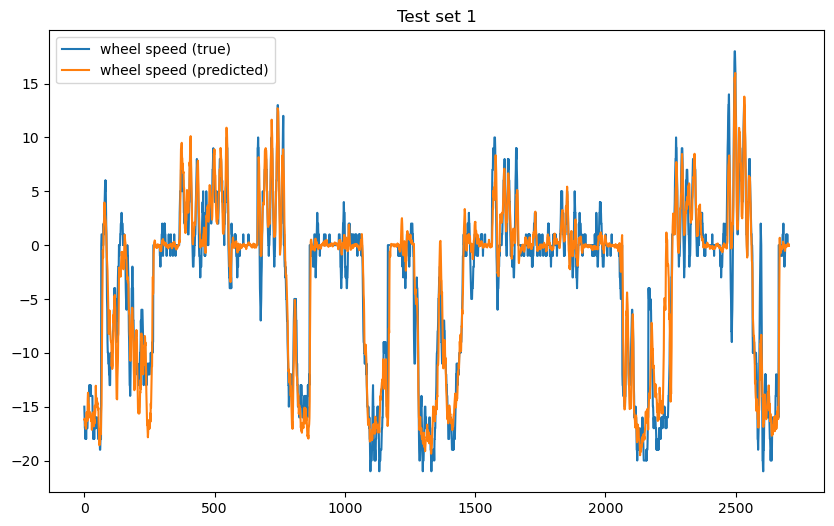

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_all[0])
plt.plot(y_pred_lstm_all[0])
plt.legend(['wheel speed (true)', 'wheel speed (predicted)'])
plt.title('Test set 1')

Text(0.5, 1.0, 'Test set 2')

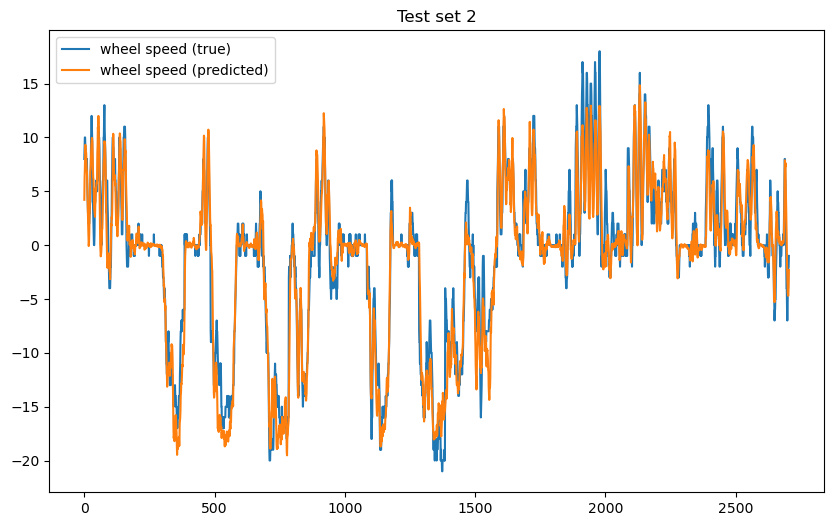

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_all[4])
plt.plot(y_pred_lstm_all[4])
plt.legend(['wheel speed (true)', 'wheel speed (predicted)'])
plt.title('Test set 2')

Text(0.5, 1.0, 'Test set 3')

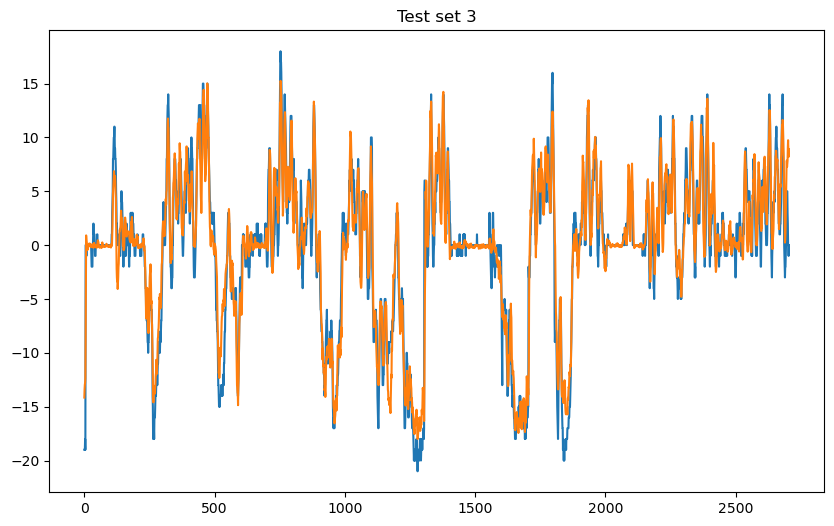

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_all[3])
plt.plot(y_pred_lstm_all[3])
#plt.legend(['wheel speed (true)', 'wheel speed (predicted)'])
plt.title('Test set 3')

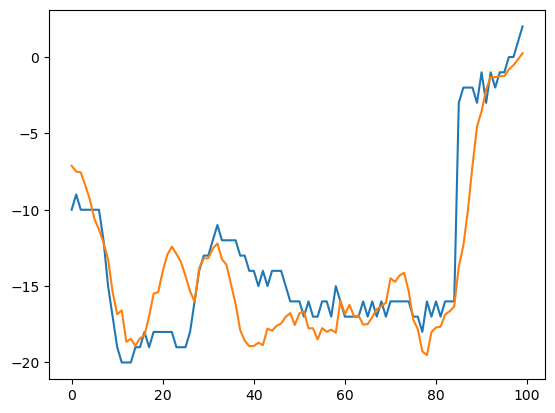

In [35]:
plt.plot(y_test_all[4][700:800])
plt.plot(y_pred_lstm_all[4][700:800])

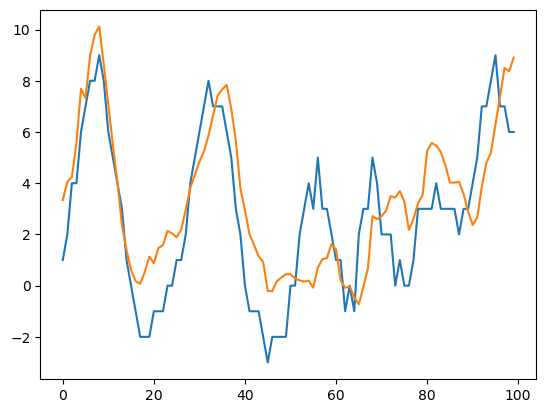

In [36]:
plt.plot(y_test_all[0][400:500])
plt.plot(y_pred_lstm_all[0][400:500])

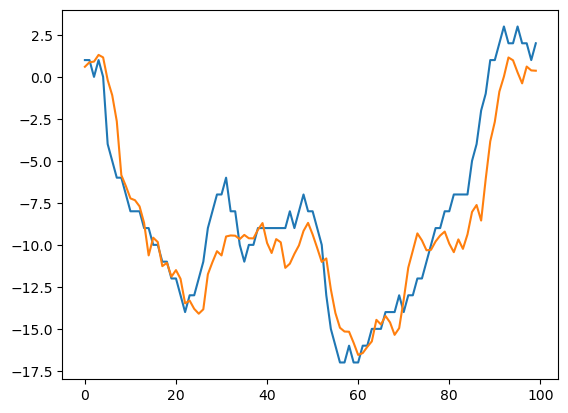

In [42]:
plt.plot(y_test_all[3][900:1000])
plt.plot(y_pred_lstm_all[3][900:1000])

**Comparison with MLP performance**

In [43]:
# import pandas as pd
# obj = pd.read_pickle(save_folder + 'results_lstm_regression_MOs_session_13_all_trials.pickle')
# print(obj)
#mat = obj["mean_r2_lstm"]

dat = pickle.load(open(save_folder + 'results_mlp_regression_MOp_session_10_all_trials_w_labels_200_units_150ms_history_correct_trials_100_time_bins.pickle', 'rb'))
#print(dat)
mat = dat["mean_r2_mlp"]
print(mat)
print(np.mean(mat))


[0.83015023 0.82260591 0.83192333 0.8943833  0.90001398 0.87818292
 0.80108838 0.83254734 0.84919321 0.81331375]
0.8453402345962251
